# Jupyter Notebook: ged_analysis.ipynb

## 1. Import necessary libraries

In [82]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install ipywidgets

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Now import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## 2. Define utility functions (for loading, cleaning, computing metrics)

In [83]:
def load_approx_results(file_path, fill_n_density=None):
    df = pd.read_excel(file_path)
    df.dropna(how='all', inplace=True)

    # Convert graph IDs to string to ensure consistent dtype
    df['graph_id_1'] = df['graph_id_1'].astype(str)
    df['graph_id_2'] = df['graph_id_2'].astype(str)

    numeric_cols = [
        'ged', 'accuracy', 'absolute_error', 'squared_error',
        'runtime', 'memory_usage_mb',
        'graph1_n', 'graph1_density', 'graph2_n', 'graph2_density'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if fill_n_density is not None:
        # Ensure fill DataFrame also has string-based IDs
        fill_n_density['graph_id_1'] = fill_n_density['graph_id_1'].astype(str)
        fill_n_density['graph_id_2'] = fill_n_density['graph_id_2'].astype(str)

        needed_cols = ['graph1_n', 'graph2_n', 'graph1_density', 'graph2_density']
        ref_cols = ['graph_id_1', 'graph_id_2'] + needed_cols
        ref = fill_n_density[ref_cols].drop_duplicates()

        merged = pd.merge(
            df, ref,
            how='left',
            on=['graph_id_1','graph_id_2'],
            suffixes=('', '_ref')
        )
        for c in needed_cols:
            merged[c] = np.where(
                merged[c].isna(),
                merged[f"{c}_ref"],
                merged[c]
            )
        drop_cols = [f"{c}_ref" for c in needed_cols if f"{c}_ref" in merged.columns]
        merged.drop(columns=drop_cols, inplace=True)
        df = merged

    df.dropna(subset=['graph_id_1','graph_id_2'], inplace=True)
    return df

def load_exact_results(file_path):
    """
    Load exact GED results from an XLSX file.
    Compute 'ged_exact' as the median of (min_ged, max_ged) if they differ,
    else min_ged (or max_ged).
    """
    df = pd.read_excel(file_path)
    df.dropna(how='all', inplace=True)

    # Convert graph IDs to string
    df['graph_id_1'] = df['graph_id_1'].astype(str)
    df['graph_id_2'] = df['graph_id_2'].astype(str)

    for col in ['min_ged', 'max_ged']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    def compute_ged_exact(row):
        if pd.notnull(row['min_ged']) and pd.notnull(row['max_ged']) and row['min_ged'] != row['max_ged']:
            return (row['min_ged'] + row['max_ged']) / 2.0
        else:
            return row['min_ged']  # or row['max_ged']

    df['ged_exact'] = df.apply(compute_ged_exact, axis=1)
    df.dropna(subset=['graph_id_1','graph_id_2','ged_exact'], inplace=True)
    return df


def compute_relative_accuracy(ged_approx, ged_exact):
    if ged_exact == 0 or ged_exact is None:
        return np.nan
    return 1 - abs(ged_approx - ged_exact) / ged_exact

## 3. Define file paths for each dataset & method

In [84]:
datasets = {
    "AIDS": {
        "HED":      r"C:\project_data\results\gedlib\AIDS\AIDS_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\AIDS\AIDS_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\AIDS\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\AIDS\merged\results.xlsx"
    },
    "IMDB-BINARY": {
        "HED":      r"C:\project_data\results\gedlib\IMDB-BINARY\IMDB-BINARY_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\IMDB-BINARY\IMDB-BINARY_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\IMDB-BINARY\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\IMDB-BINARY\merged\results.xlsx"
    },
    "PROTEINS": {
        "HED":      r"C:\project_data\results\gedlib\PROTEINS\PROTEINS_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\PROTEINS\PROTEINS_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\PROTEINS\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\PROTEINS\merged\results.xlsx"
    }
}

## 4. Load data for each dataset & method

In [85]:
data = {}

for dset, paths in datasets.items():
    df_simgnn = load_approx_results(paths["SimGNN"])
    df_exact  = load_exact_results(paths["Exact"])

    df_hed  = load_approx_results(paths["HED"], fill_n_density=df_simgnn)
    df_ipfp = load_approx_results(paths["IPFP"], fill_n_density=df_simgnn)
    # For consistency, fill SimGNN from itself:
    df_simgnn_filled = load_approx_results(paths["SimGNN"], fill_n_density=df_simgnn)

    # Merge approximate with exact (intersection in memory)
    df_hed  = pd.merge(df_hed,  df_exact, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))
    df_ipfp = pd.merge(df_ipfp, df_exact, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))
    df_simgnn_filled = pd.merge(df_simgnn_filled, df_exact, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))

    # Compute metrics
    for df_approx in [df_hed, df_ipfp, df_simgnn_filled]:
        if 'ged_exact' in df_approx.columns and 'ged' in df_approx.columns:
            df_approx['absolute_error'] = abs(df_approx['ged'] - df_approx['ged_exact'])
            df_approx['squared_error']  = (df_approx['ged'] - df_approx['ged_exact'])**2
            df_approx['accuracy']       = df_approx.apply(
                lambda row: compute_relative_accuracy(row['ged'], row['ged_exact'])
                            if pd.notnull(row['ged_exact']) else np.nan,
                axis=1
            )
            df_approx['graph_size'] = (df_approx['graph1_n'] + df_approx['graph2_n']) / 2.0
            df_approx['graph_density'] = (df_approx['graph1_density'] + df_approx['graph2_density']) / 2.0

    data[dset] = {
        "HED":    df_hed,
        "IPFP":   df_ipfp,
        "SimGNN": df_simgnn_filled
    }


## 5. Generate correlation plots for each dataset

In [86]:
from scipy.stats import gaussian_kde

def filter_valid_accuracy(df):
    """
    Example helper to keep only rows with accuracy > 0 (if desired).
    If you want all rows (including zero or negative?), remove this filter.
    """
    return df[df['accuracy'] >= 0].dropna(subset=['accuracy', 'graph_size', 'graph_density'])

def filter_common_pairs(dset):
    """
    Returns a dictionary with filtered DataFrames for each method (HED, IPFP, SimGNN)
    containing only the common graph pairs (i.e. rows where (graph_id_1, graph_id_2) appear in all three methods).
    """
    methods = ["HED", "IPFP", "SimGNN"]
    common_pairs = None
    for method in methods:
        df_method = data[dset][method]
        pairs = set(zip(df_method["graph_id_1"], df_method["graph_id_2"]))
        if common_pairs is None:
            common_pairs = pairs
        else:
            common_pairs = common_pairs.intersection(pairs)
    filtered = {}
    for method in methods:
        df_method = data[dset][method]
        filtered[method] = df_method[df_method.apply(lambda row: (row["graph_id_1"], row["graph_id_2"]) in common_pairs, axis=1)]
    return filtered


In [87]:
def plot_accuracy_hist_by_size(dset, bins=20):
    """
    For the chosen dataset `dset`, create density plots arranged vertically (one per method)
    for three graph-size categories:
      1) Small (<50 nodes)
      2) Medium (50–100 nodes)
      3) Large (>100 nodes)

    Each subplot shows the density curve (computed via a kernel density estimator) with fill under the curve.
    The methods (HED, IPFP, SimGNN) are ordered by their median accuracy.

    IMPORTANT: For HED and IPFP, we retrieve the 'graph_size' from the SimGNN data
    by merging on (graph_id_1, graph_id_2). This ensures consistent graph_size values.
    """

    methods = ["HED", "IPFP", "SimGNN"]

    def get_df_with_simgnn_size(dset, method):
        """
        Merge the given method's DataFrame with the SimGNN DataFrame
        to use the 'graph_size' from SimGNN.
        """
        # Original data for the chosen method
        df_method = data[dset][method].copy()
        # SimGNN data with graph_size
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_size"]]

        # Merge on graph IDs
        df_merged = pd.merge(
            df_method, df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )
        # Overwrite graph_size with the one from SimGNN
        df_merged["graph_size"] = df_merged["graph_size_simgnn"]
        return df_merged

    def plot_density(ax, data_series, method_label):
        """
        Helper to plot a kernel density estimate (KDE) with fill.
        """
        if data_series.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            return
        x_min, x_max = data_series.min(), data_series.max()
        # Create a range of 100 points between min and max
        x_range = np.linspace(x_min, x_max, 100)
        # Compute KDE
        kde = gaussian_kde(data_series)
        y = kde(x_range)
        # Plot the density line
        ax.plot(x_range, y, label=method_label)
        # Fill under the curve
        ax.fill_between(x_range, y, alpha=0.3)
        ax.legend()
        ax.grid(True)

    # Define categories for small, medium, large
    categories = [
        ("Small (<50 nodes)",   lambda df: df["graph_size"] < 50),
        ("Medium (50–100 nodes)", lambda df: (df["graph_size"] >= 50) & (df["graph_size"] <= 100)),
        ("Large (>100 nodes)", lambda df: df["graph_size"] > 100)
    ]

    for cat_title, cat_filter in categories:
        # Gather data for each method in this category
        method_data = []
        for method in methods:
            # Merge method data with SimGNN graph_size
            df_merged = get_df_with_simgnn_size(dset, method)
            # Filter out rows where accuracy <= 0 or is NaN, etc. (as in filter_valid_accuracy)
            df_valid = filter_valid_accuracy(df_merged)
            # Apply the category filter (small, medium, large)
            df_cat = df_valid[cat_filter(df_valid)]

            # Compute median accuracy
            median_val = df_cat["accuracy"].median() if not df_cat.empty else np.nan
            method_data.append((method, df_cat, median_val))

        # Order methods by median accuracy
        method_data_sorted = sorted(method_data, key=lambda x: (np.nan if np.isnan(x[2]) else x[2]))

        # Create one subplot per method, stacked vertically
        fig, axs = plt.subplots(nrows=len(methods), figsize=(8, 3*len(methods)), dpi=120, sharex=True)
        if len(methods) == 1:
            axs = [axs]

        # Plot each method in a separate subplot
        for ax, (method, df_cat, median_val) in zip(axs, method_data_sorted):
            if not df_cat.empty:
                label = f"{method} (median={median_val:.2f})"
                plot_density(ax, df_cat["accuracy"], label)
            else:
                ax.text(0.5, 0.5, f"{method}: No data", ha='center', va='center', transform=ax.transAxes)
            ax.set_ylabel("Density")

        plt.suptitle(f"{dset} — {cat_title} Accuracy Density by Method")
        plt.xlabel("Relative Accuracy")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [88]:
def plot_accuracy_hist_by_density(dset, density_threshold=0.1, bins=20):
    """
    For the chosen dataset `dset`, create density plots arranged vertically (one per method)
    for two graph-density categories:
      1) Sparse (graph_density < threshold)
      2) Dense (graph_density >= threshold)

    Each subplot shows the density curve (computed via a kernel density estimator) with fill under the curve.
    The methods (HED, IPFP, SimGNN) are ordered by their median accuracy.

    IMPORTANT: For HED and IPFP, we retrieve the 'graph_density' from the SimGNN data
    by merging on (graph_id_1, graph_id_2). This ensures consistent graph_density values
    across methods.
    """

    methods = ["HED", "IPFP", "SimGNN"]

    def get_df_with_simgnn_density(dset, method):
        """
        Merge the given method's DataFrame with the SimGNN DataFrame
        to use the 'graph_density' from SimGNN.
        """
        # Original data for the chosen method
        df_method = data[dset][method].copy()
        # SimGNN data with graph_density
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_density"]]

        # Merge on graph IDs
        df_merged = pd.merge(
            df_method, df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )
        # Overwrite graph_density with the one from SimGNN
        df_merged["graph_density"] = df_merged["graph_density_simgnn"]
        return df_merged

    def plot_density(ax, data_series, method_label):
        """
        Helper to plot a kernel density estimate (KDE) with fill.
        """
        if data_series.empty:
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes)
            return
        x_min, x_max = data_series.min(), data_series.max()
        x_range = np.linspace(x_min, x_max, 100)
        kde = gaussian_kde(data_series)
        y = kde(x_range)
        ax.plot(x_range, y, label=method_label)
        ax.fill_between(x_range, y, alpha=0.3)
        ax.legend()
        ax.grid(True)

    # Categories: (Title, filter function)
    categories = [
        (f"Sparse (density < {density_threshold})", lambda df: df["graph_density"] < density_threshold),
        (f"Dense (density ≥ {density_threshold})", lambda df: df["graph_density"] >= density_threshold)
    ]

    for cat_title, cat_filter in categories:
        # Gather per-method data and compute median accuracy
        method_data = []
        for method in methods:
            # Merge method data with SimGNN density
            df_merged = get_df_with_simgnn_density(dset, method)
            # Filter valid accuracy (as in your original code)
            df_valid = filter_valid_accuracy(df_merged)
            # Apply the category filter
            df_cat = df_valid[cat_filter(df_valid)]

            median_val = df_cat["accuracy"].median() if not df_cat.empty else np.nan
            method_data.append((method, df_cat, median_val))

        # Order methods by median accuracy
        method_data_sorted = sorted(method_data, key=lambda x: (np.nan if np.isnan(x[2]) else x[2]))

        # Create one subplot per method, stacked vertically
        fig, axs = plt.subplots(nrows=len(methods), figsize=(8, 3*len(methods)), dpi=120, sharex=True)
        if len(methods) == 1:
            axs = [axs]

        # Plot each method in a separate subplot
        for ax, (method, df_cat, median_val) in zip(axs, method_data_sorted):
            if not df_cat.empty:
                label = f"{method} (median={median_val:.2f})"
                plot_density(ax, df_cat["accuracy"], label)
            else:
                ax.text(0.5, 0.5, f"{method}: No data", ha='center', va='center',
                        transform=ax.transAxes)
            ax.set_ylabel("Density")

        plt.suptitle(f"{dset} — {cat_title} Accuracy Density by Method")
        plt.xlabel("Relative Accuracy")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


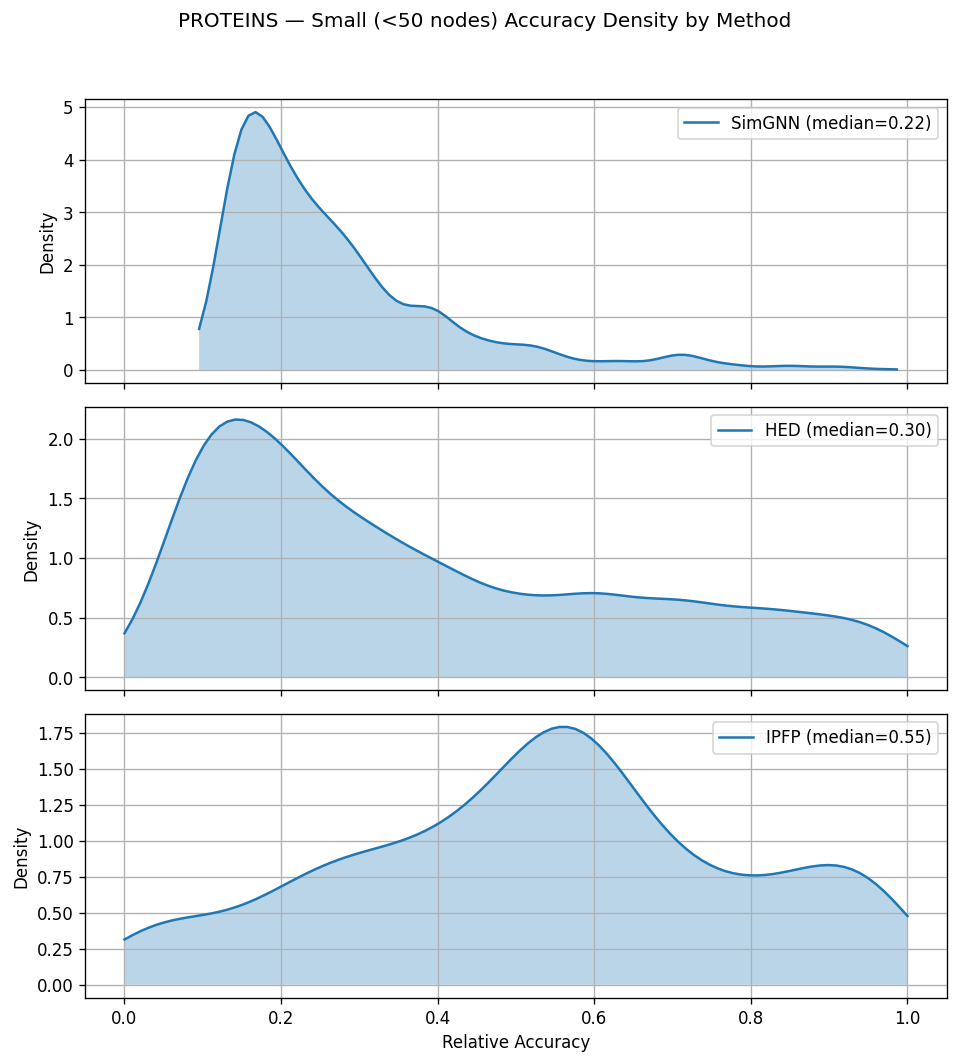

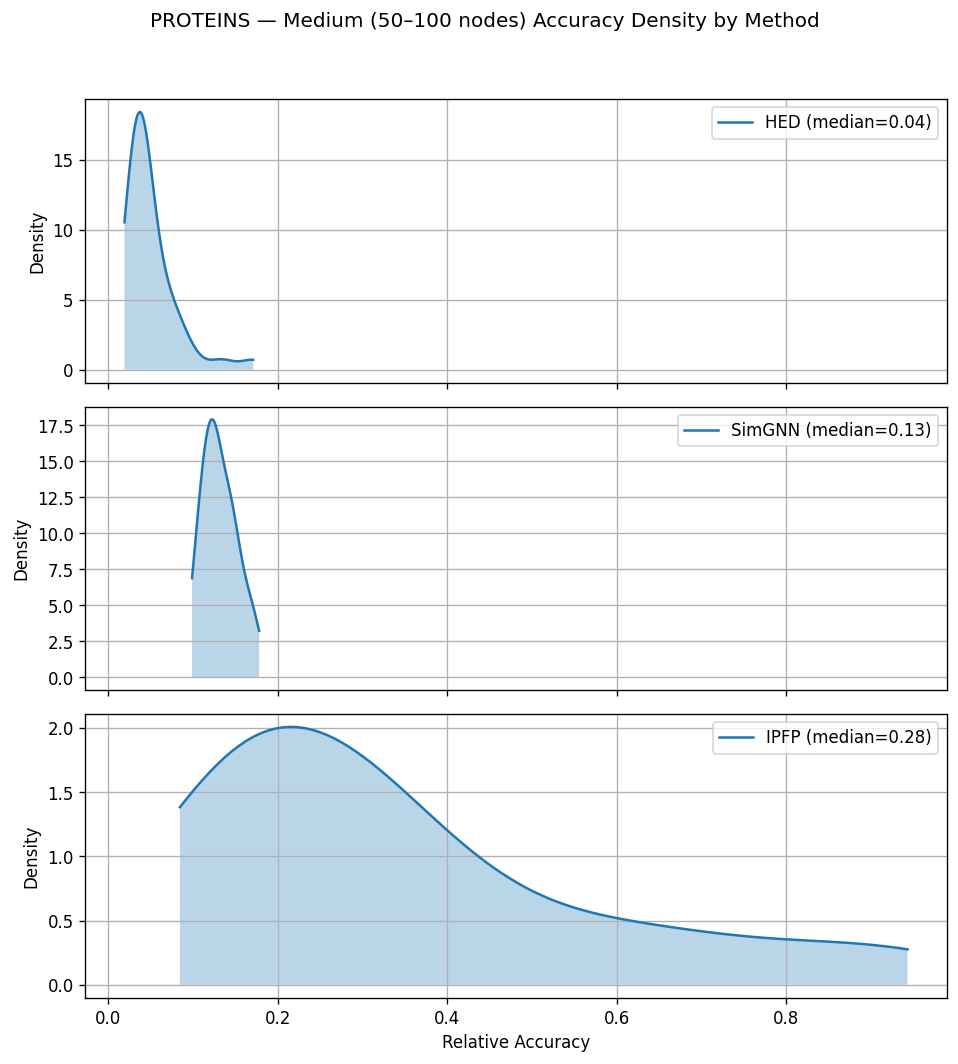

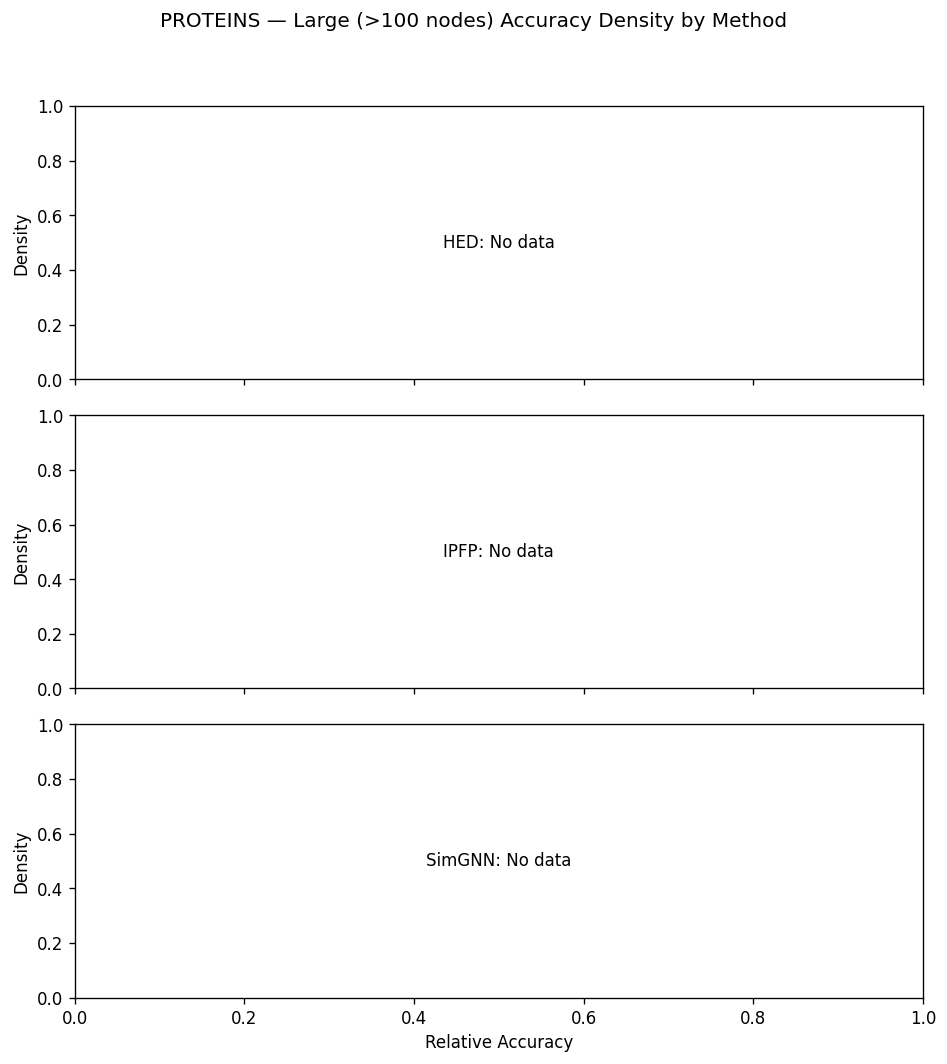

In [99]:
plot_accuracy_hist_by_size(dset="PROTEINS", bins=20)

## 7. Scatter plot for Accuracy Analysis

In [90]:
import matplotlib as mpl

def plot_accuracy_scatter(dset, method):
    """
    For the chosen dataset `dset` and given `method`, create a 2D hexbin plot
    comparing the approximate GED results (ged) against the exact GED results (ged_exact).

    Each hexagon is colored by the count of observations in that bin,
    using a custom lavender colormap from very light (#E6E6FA) to bright (#8A2BE2).
    The diagonal (y = x) represents the exact GED.
    The figure is sized to an HD-like resolution (1280x720).
    """

    # Define a custom lavender colormap from light to bright
    lavender_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "LavenderMap",
        ["#8A2BE2", "#B299FF", "#E6E6FA"]  # Light → Medium → Bright lavender
    )

    # Set HD-like resolution: 12.8" x 7.2" at 100 DPI ~ 1280 x 720 pixels
    plt.figure(figsize=(12.8, 7.2), dpi=100)

    # Collect all (x, y) points for the chosen method
    all_exact = []
    all_approx = []
    df_method = data[dset][method].dropna(subset=['ged', 'ged_exact'])
    all_exact.extend(df_method["ged_exact"].tolist())
    all_approx.extend(df_method["ged"].tolist())

    # Plot hexbin only if we have points
    if all_exact and all_approx:
        hb = plt.hexbin(
            all_exact,
            all_approx,
            gridsize=50,          # number of hexagons along each axis
            cmap=lavender_cmap,   # our custom lavender colormap
            mincnt=1              # only color bins that have at least one point
        )
        cb = plt.colorbar(hb)
        cb.set_label("Count")

        # Draw the diagonal
        lower = min(min(all_exact), min(all_approx))
        upper = max(max(all_exact), max(all_approx))
        plt.plot([lower, upper], [lower, upper], 'k--', label="Exact GED (y = x)")

    # Clamp axes to [0, 250]
    limit = 250
    plt.xlim(0, limit)
    plt.ylim(0, limit)

    plt.title(f"{dset} — Approximate GED vs Exact GED (Hexbin: {method})")
    plt.xlabel("Exact GED")
    plt.ylabel("Approximate GED")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

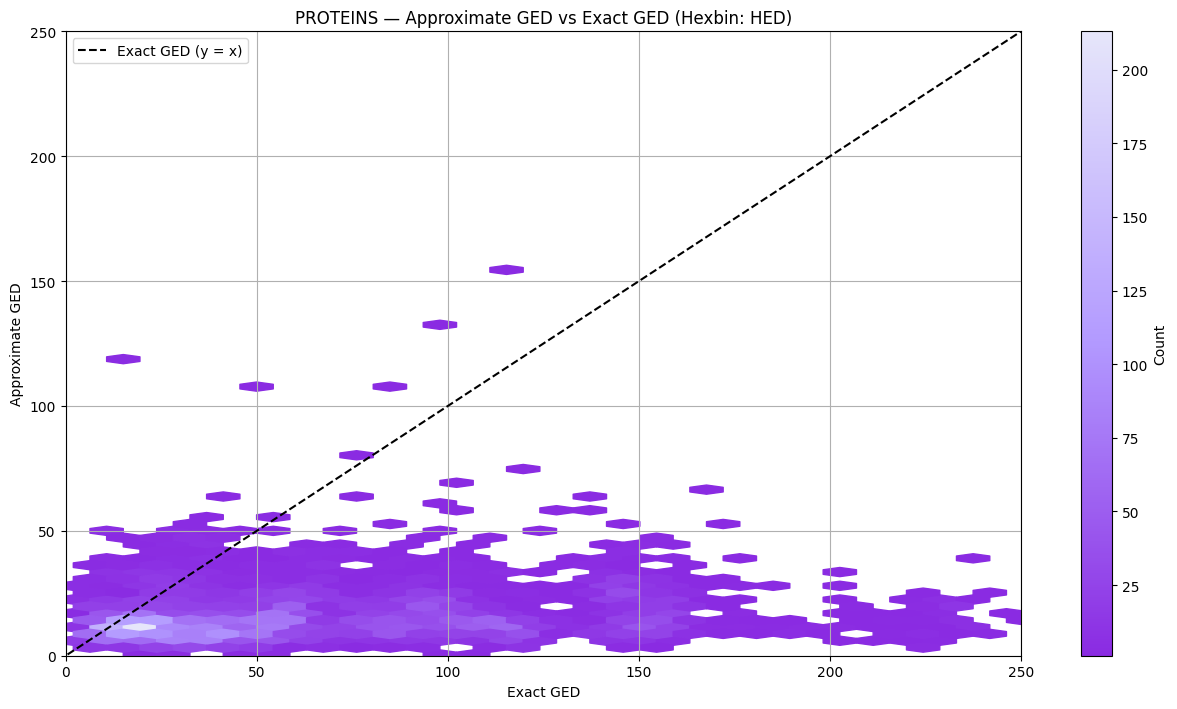

In [91]:
    plot_accuracy_scatter("PROTEINS", "HED")

In [92]:
!{sys.executable} -m pip install statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [93]:
def plot_runtime_by_size(dset):
    """
    Plots the runtime (in ms) vs. graph size for each method (HED, IPFP, SimGNN),
    with a black line showing the grouped average runtime, and a LOESS smooth
    curve (colored lavender).
    """
    methods = ["HED", "IPFP", "SimGNN"]

    fig, axes = plt.subplots(nrows=len(methods), figsize=(8, 10), sharex=True, dpi=120)

    # If there's only one method, axes is not a list
    if len(methods) == 1:
        axes = [axes]

    for i, method in enumerate(methods):
        df_method = data[dset][method]
        # Print debug info if desired
        # print(f"Method: {method}, initial shape: {df_method.shape}")
        # print(f"Method: {method}, missing runtime count: {df_method['runtime'].isna().sum()}")

        # Drop rows with missing runtime
        df_method = df_method.dropna(subset=["runtime"])
        # print(f"Method: {method}, after dropping missing runtime, shape: {df_method.shape}")

        # Merge to get graph_size from SimGNN if needed
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_size"]]
        df_method = pd.merge(
            df_method,
            df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )
        df_method["graph_size"] = df_method["graph_size_simgnn"]
        df_method = df_method.dropna(subset=["graph_size", "runtime"])

        if df_method.empty:
            axes[i].text(0.5, 0.5, f"No data for {method}",
                         ha='center', va='center', transform=axes[i].transAxes)
            continue

        # Convert runtime to milliseconds
        df_method["runtime_ms"] = df_method["runtime"] * 1000

        # Convert graph_size to integer for grouping
        df_method["graph_size_int"] = df_method["graph_size"].astype(int)

        # Group by integer graph size
        grouped = (
            df_method.groupby("graph_size_int")["runtime_ms"]
            .mean()
            .reset_index()
            .sort_values("graph_size_int")
        )

        # Plot average runtime as a black line (or scatter if only 1 point)
        if grouped["graph_size_int"].nunique() > 1:
            axes[i].plot(grouped["graph_size_int"], grouped["runtime_ms"], color="black")
        else:
            axes[i].scatter(grouped["graph_size_int"], grouped["runtime_ms"], color="black")

        # --- Add LOESS smooth curve in lavender ---
        # Only do LOESS if we have multiple x-values
        if grouped["graph_size_int"].nunique() > 1:
            x_vals = grouped["graph_size_int"].values
            y_vals = grouped["runtime_ms"].values

            # frac=0.3 controls the smoothness; adjust as needed
            loess_smoothed = lowess(endog=y_vals, exog=x_vals, frac=0.3)
            # loess_smoothed is Nx2 array: first column x, second column smoothed y
            axes[i].plot(
                loess_smoothed[:, 0],
                loess_smoothed[:, 1],
                color="red",
                linewidth=2,
                label="LOESS Smooth"
            )

        axes[i].set_title(f"{method}")
        axes[i].set_ylabel("Runtime (ms)")
        axes[i].grid(True)

        # Set x-limits based on min and max integer graph size
        min_size = grouped["graph_size_int"].min()
        max_size = 60 #grouped["graph_size_int"].max()
        axes[i].set_xlim(min_size - 1, max_size + 1)

        # Optionally add a legend
        axes[i].legend(loc="best")

    # Shared X-axis label
    axes[-1].set_xlabel("Graph Size")
    fig.suptitle(f"{dset} — Runtime by Graph Size")
    plt.tight_layout()
    plt.show()


In [94]:
def plot_runtime_by_density(dset):
    """
    Plots the runtime (in ms) vs. graph density (0–1) for each method (HED, IPFP, SimGNN).
    A black line shows the binned average runtime, and a LOESS smooth curve in lavender
    is superimposed to show the smoothed trend.

    The figure is sized to HD-like resolution (1280x720).
    """
    methods = ["HED", "IPFP", "SimGNN"]

    fig, axes = plt.subplots(nrows=len(methods), figsize=(12.8, 7.2), sharex=True, dpi=100)

    # If there's only one method in the list, axes won't be a list
    if len(methods) == 1:
        axes = [axes]

    for i, method in enumerate(methods):
        df_method = data[dset][method]

        # Drop rows with missing runtime
        df_method = df_method.dropna(subset=["runtime"])

        # Merge to get graph_density from SimGNN if needed
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_density"]]
        df_method = pd.merge(
            df_method,
            df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )

        df_method["graph_density"] = df_method["graph_density_simgnn"]
        df_method = df_method.dropna(subset=["graph_density", "runtime"])
        if df_method.empty:
            axes[i].text(0.5, 0.5, f"No data for {method}", ha='center', va='center',
                         transform=axes[i].transAxes)
            continue

        # Convert runtime to milliseconds
        df_method["runtime_ms"] = df_method["runtime"] * 1000

        # Bin density in [0..100]
        df_method["density_bin"] = (df_method["graph_density"] * 100).astype(int)
        df_plot = df_method[
            (df_method["density_bin"] >= 0) &
            (df_method["density_bin"] <= 100)
        ]

        # Group by binned density and compute average runtime
        grouped = df_plot.groupby("density_bin")["runtime_ms"].mean().reset_index()
        grouped["density_float"] = grouped["density_bin"] / 100.0

        # Plot the average runtime as black line (or scatter if only one bin)
        if grouped["density_bin"].nunique() > 1:
            axes[i].plot(grouped["density_float"], grouped["runtime_ms"], color="black")
        else:
            axes[i].scatter(grouped["density_float"], grouped["runtime_ms"], color="black")

        # --- Add LOESS smooth curve in lavender ---
        if grouped["density_bin"].nunique() > 1:
            x_vals = grouped["density_float"].values
            y_vals = grouped["runtime_ms"].values

            # frac=0.3 controls smoothing; adjust if desired
            loess_smoothed = lowess(endog=y_vals, exog=x_vals, frac=0.3)
            # loess_smoothed is Nx2 array: first col = x, second col = smoothed y
            axes[i].plot(
                loess_smoothed[:, 0],
                loess_smoothed[:, 1],
                color="red",
                linewidth=2,
                label="LOESS Smooth"
            )
            axes[i].legend(loc="best")

        axes[i].set_title(f"{method}")
        axes[i].set_ylabel("Runtime (ms)")
        axes[i].grid(True)

    axes[-1].set_xlabel("Graph Density (0–1)")
    axes[-1].set_xlim(0, 1)

    fig.suptitle(f"{dset} — Runtime by Density")
    plt.tight_layout()
    plt.show()


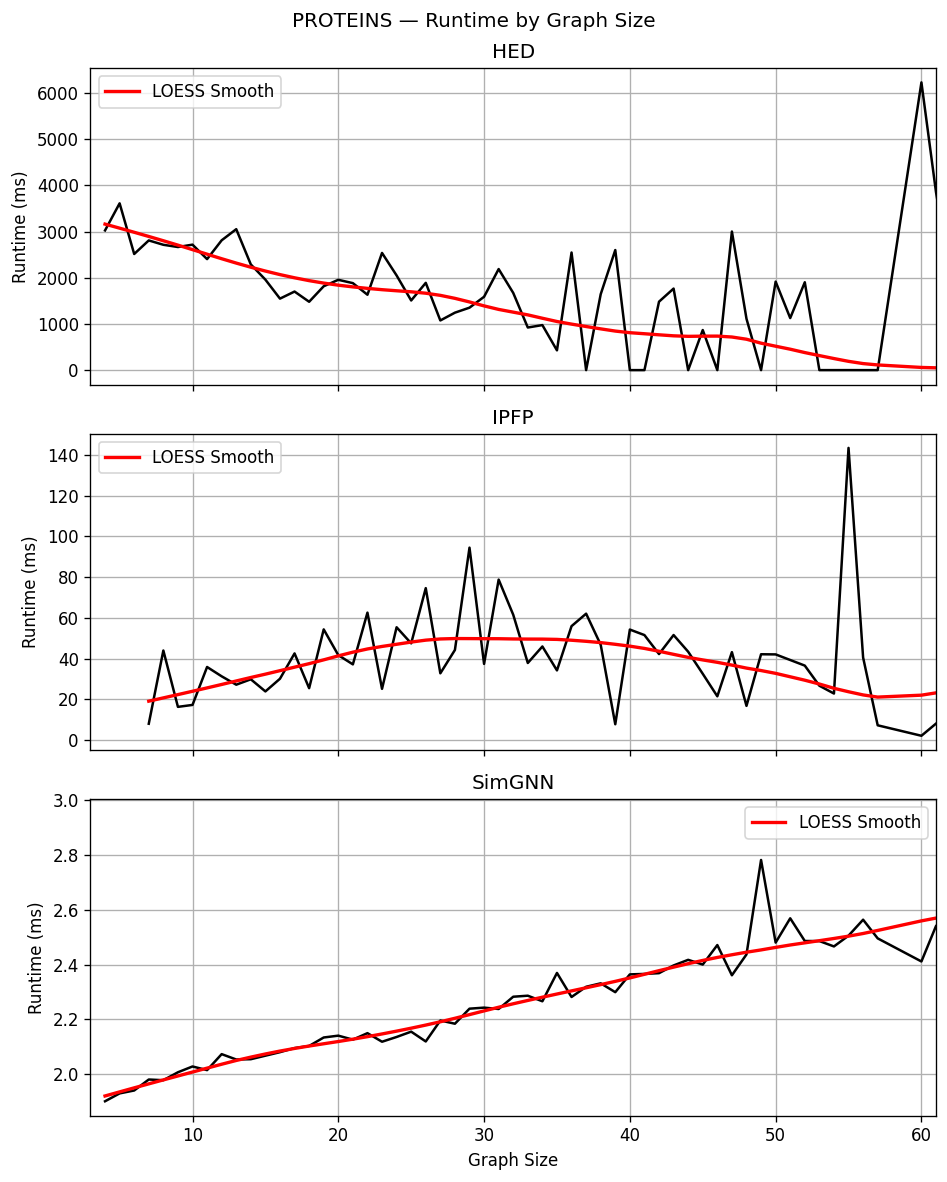

In [95]:
plot_runtime_by_size("PROTEINS")

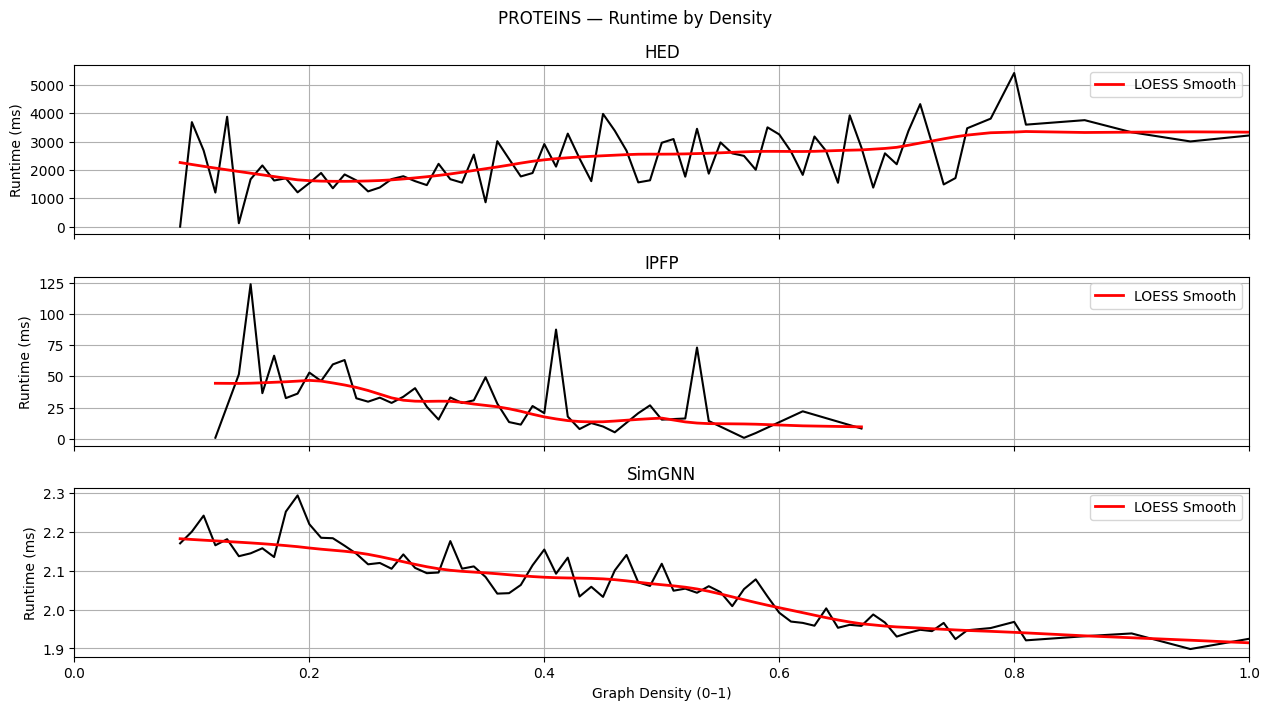

In [96]:
plot_runtime_by_density("PROTEINS")

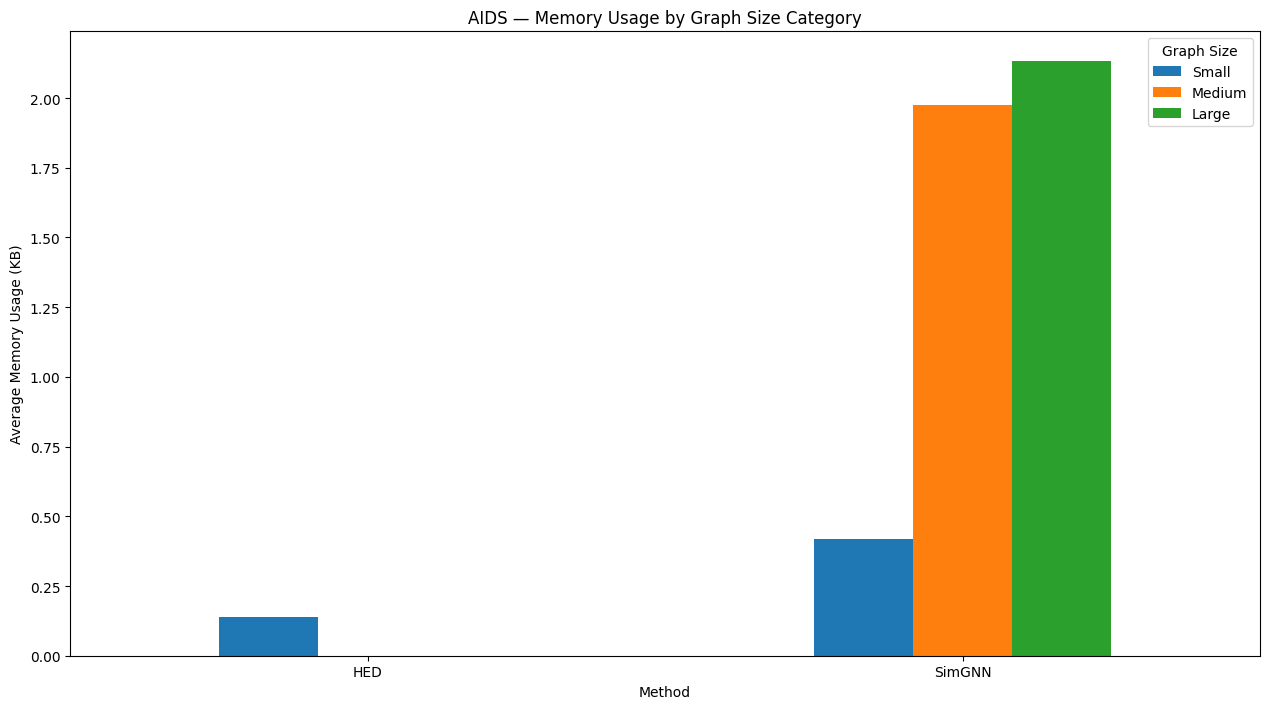

In [102]:
def plot_memory_usage_bar(dset):
    """
    Create a bar plot of average memory usage (in KB) for HED, IPFP, and SimGNN,
    subdivided into three graph-size categories (Small, Medium, Large).

    - We determine min and max graph sizes from SimGNN data.
    - We split that range into three equal intervals.
    - We merge each method’s data with SimGNN’s graph_size using (graph_id_1, graph_id_2).
    - We convert memory_usage_mb to memory_usage_kb.
    - We compute average memory usage for each size category (Small, Medium, Large).
    - We display a grouped bar chart where the x-axis is the algorithm name, and the legend is the size category.
    - The plot resolution is set to HD-like (1280×720).
    """

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    methods = ["HED", "IPFP", "SimGNN"]

    # 1) Get SimGNN data for reference graph_size
    df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_size"]].copy()
    df_simgnn.dropna(subset=["graph_size"], inplace=True)

    if df_simgnn.empty:
        print(f"No SimGNN graph_size data available for dataset {dset}. Cannot plot memory usage.")
        return

    # 2) Determine min and max graph sizes, then define boundaries for three intervals
    min_size = df_simgnn["graph_size"].min()
    max_size = df_simgnn["graph_size"].max()
    if min_size == max_size:
        print(f"All graphs have the same size ({min_size}); cannot split into multiple ranges.")
        return

    size_range = max_size - min_size
    boundary1 = min_size + (size_range / 3.0)
    boundary2 = min_size + (2.0 * size_range / 3.0)

    def categorize_size(x):
        if x < boundary1:
            return "Small"
        elif x < boundary2:
            return "Medium"
        else:
            return "Large"

    # 3) Build a list of average memory usage by method and size category
    results = []

    for method in methods:
        # Merge method’s data with SimGNN’s graph_size
        df_method = data[dset][method].copy()
        df_merged = pd.merge(
            df_method,
            df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )

        # Overwrite the method’s graph_size with SimGNN’s
        df_merged["graph_size"] = df_merged["graph_size_simgnn"]
        df_merged.drop(columns=["graph_size_simgnn"], inplace=True, errors="ignore")

        # Keep rows that have memory_usage_mb and graph_size
        df_merged = df_merged.dropna(subset=["memory_usage_mb", "graph_size"])
        if df_merged.empty:
            # If there's no valid data for this method, skip
            continue

        # Convert MB to KB
        df_merged["memory_usage_kb"] = df_merged["memory_usage_mb"] * 1024.0

        # Categorize by size
        df_merged["size_category"] = df_merged["graph_size"].apply(categorize_size)

        # Group by size_category and compute mean memory usage
        grouped = df_merged.groupby("size_category")["memory_usage_kb"].mean().reset_index()

        for _, row in grouped.iterrows():
            results.append({
                "method": method,
                "size_category": row["size_category"],
                "avg_mem_kb": row["memory_usage_kb"]
            })

    if not results:
        print(f"No memory usage data found for dataset {dset}.")
        return

    df_results = pd.DataFrame(results)
    # Pivot so that each method is a row and columns are size categories
    df_pivot = df_results.pivot(index="method", columns="size_category", values="avg_mem_kb")

    # Ensure columns order: Small, Medium, Large (if they exist)
    for cat in ["Small", "Medium", "Large"]:
        if cat not in df_pivot.columns:
            df_pivot[cat] = np.nan
    df_pivot = df_pivot[["Small", "Medium", "Large"]]

    # 4) Plot the grouped bar chart
    fig, ax = plt.subplots(figsize=(12.8, 7.2), dpi=100)  # HD-like resolution
    df_pivot.plot(kind="bar", ax=ax)

    ax.set_ylabel("Average Memory Usage (KB)")
    ax.set_title(f"{dset} — Memory Usage by Graph Size Category")
    ax.legend(title="Graph Size")
    ax.set_xlabel("Method")
    plt.xticks(rotation=0)  # Keep method labels horizontal
    plt.tight_layout()
    plt.show()

plot_memory_usage_bar("AIDS")